In [1]:
import nltk
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel,cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize,PorterStemmer
import re
import string
import matplotlib.pyplot as plt

## Hotel Recommender

#### Reading Data

In [2]:
hotels = pd.read_csv('Hotels_features_dataset.csv')
# hotels = hotels.T

In [3]:
hotels.head()

,name,country,street,region,rating,reviews,amenities,rooms,types,price,official_description
0,WH Hotel,Lebanon,Lyon Street Hamra Emille Edde,NaN,4.0,"{'Excellent': 104, 'Good': 102, 'Average': 51,...","Free High Speed Internet (WiFi),Free breakfast...","Air conditioning,Fireplace,Housekeeping,Room s...","Non-smoking rooms,Suites,Family rooms,Smoking ...",NaN,NaN
1,Le Patio Boutique Hotel,Lebanon,"1144 Marfaa, Uruguay Street Solidere",NaN,4.5,"{'Excellent': 213, 'Good': 78, 'Average': 31, ...","Paid private parking nearby,Free High Speed In...","Air conditioning,Housekeeping,Room service,Saf...","Non-smoking rooms,Suites,Family rooms,Smoking ...",121.0,NaN
2,Riviera Hotel Beirut,Lebanon,"Avenue De Paris, Corniche El Manara Riad El Solh",NaN,3.5,"{'Excellent': 90, 'Good': 101, 'Average': 69, ...","Valet parking,Free High Speed Internet (WiFi),...","Air conditioning,Private balcony,Room service,...","Ocean view,Pool view,Non-smoking rooms,Suites,...",NaN,NaN
3,Le Bristol Beyrouth,Lebanon,Mme Curie Street Verdun,NaN,4.5,"{'Excellent': 219, 'Good': 79, 'Average': 25, ...","Free High Speed Internet (WiFi),Pool,Fitness C...","Air conditioning,Room service,Safe,VIP room fa...","Non-smoking rooms,Suites,Family rooms,Smoking ...",NaN,NaN
4,Golden Tulip Midtown Hotel And Suites,Lebanon,"Building Number 483, Sidani / Souraty Street M...",NaN,4.0,"{'Excellent': 147, 'Good': 86, 'Average': 32, ...","Free parking,Free High Speed Internet (WiFi),P...","Air conditioning,Room service,Safe,Kitchenette...","Non-smoking rooms,Suites,Family rooms,Smoking ...",NaN,NaN


### Feature Extraction

In [4]:
features = set()

In [5]:
hotels['amenities'][0]

'Free High Speed Internet (WiFi),Free breakfast,Airport transportation,Business Center with Internet Access,Conference facilities,Baggage storage,Concierge,Dry cleaning,Wifi,Bar / lounge,Restaurant,Breakfast available,Breakfast buffet,Car hire,Banquet room,Meeting rooms,Currency exchange,Laundry service,Air conditioning,Fireplace,Housekeeping,Room service,Minibar,Refrigerator,Flatscreen TV,Non-smoking rooms,Suites,Family rooms,Smoking rooms available'

In [6]:
hotels['amenities'].apply(lambda item: [features.add(x) for x in str(item).split(',')])
hotels['rooms'].apply(lambda item: [features.add(x) for x in str(item).split(',')])

0        [None, None, None, None, None, None, None, Non...
1        [None, None, None, None, None, None, None, Non...
2        [None, None, None, None, None, None, None, Non...
3        [None, None, None, None, None, None, None, Non...
4        [None, None, None, None, None, None, None, Non...
                               ...                        
70102    [None, None, None, None, None, None, None, Non...
70103    [None, None, None, None, None, None, None, Non...
70104           [None, None, None, None, None, None, None]
70105    [None, None, None, None, None, None, None, Non...
70106    [None, None, None, None, None, None, None, Non...
Name: rooms, Length: 70107, dtype: object

In [7]:
features

{' DVDs',
 ' music for children',
 '24-hour check-in',
 '24-hour front desk',
 '24-hour security',
 'ATM on site',
 'Additional bathroom',
 'Adult pool',
 'Adults only',
 'Aerobics',
 'Aerobics offsite',
 'Air conditioning',
 'Air purifier',
 'Airport transportation',
 'Allergy-free room',
 'Archery',
 'Archery offsite',
 'BBQ facilities',
 'Babysitting',
 'Badminton',
 'Baggage storage',
 'Banquet room',
 'Bar / lounge',
 'Bath / shower',
 'Bathrobes',
 'Beach',
 'Bicycle rental',
 'Bicycle tours',
 'Bicycles available',
 'Bidet',
 'Billiards',
 'Blackout curtains',
 'Board games / puzzles',
 'Boating',
 'Body wrap',
 'Books',
 'Bottled water',
 'Bowling',
 'Bowling offsite',
 'Breakfast available',
 'Breakfast buffet',
 'Breakfast in the room',
 'Bridal suite',
 'Business Center with Internet Access',
 'Butler service',
 'Cable / satellite TV',
 'Canoeing',
 'Canoeing offsite',
 'Car hire',
 'Casino and Gambling',
 'Chapel / shrine',
 'Children Activities (Kid / Family Friendly)',
 "

In [8]:
features = {x for x in features if pd.notna(x) or x != ''}

In [9]:
features.discard('')
features.discard('nan')
# features.discard(' DVDs')
# features.discard(' music for children')

In [10]:
features

{' DVDs',
 ' music for children',
 '24-hour check-in',
 '24-hour front desk',
 '24-hour security',
 'ATM on site',
 'Additional bathroom',
 'Adult pool',
 'Adults only',
 'Aerobics',
 'Aerobics offsite',
 'Air conditioning',
 'Air purifier',
 'Airport transportation',
 'Allergy-free room',
 'Archery',
 'Archery offsite',
 'BBQ facilities',
 'Babysitting',
 'Badminton',
 'Baggage storage',
 'Banquet room',
 'Bar / lounge',
 'Bath / shower',
 'Bathrobes',
 'Beach',
 'Bicycle rental',
 'Bicycle tours',
 'Bicycles available',
 'Bidet',
 'Billiards',
 'Blackout curtains',
 'Board games / puzzles',
 'Boating',
 'Body wrap',
 'Books',
 'Bottled water',
 'Bowling',
 'Bowling offsite',
 'Breakfast available',
 'Breakfast buffet',
 'Breakfast in the room',
 'Bridal suite',
 'Business Center with Internet Access',
 'Butler service',
 'Cable / satellite TV',
 'Canoeing',
 'Canoeing offsite',
 'Car hire',
 'Casino and Gambling',
 'Chapel / shrine',
 'Children Activities (Kid / Family Friendly)',
 "

In [11]:
features_df = pd.DataFrame(columns=features)

In [12]:
features_df

,Ski rentals,Rooftop terrace,Aerobics offsite,hotel_amenity_banquet_room,hotel_amenity_breakfast_in_the_room,hotel_amenity_bridal_suite,Fence around pool,Paid internet,hotel_amenity_public_wifi,hotel_amenity_wine_champagne,...,hotel_amenity_private_balcony,Kid-friendly buffet,Ironing service,Raquetball,Kids' meals,Wine / champagne,hotel_amenity_badminton,Hair dryer,VIP room facilities,Photo copier / fax In business center


#### Getting each hotel feature as a Vector

In [13]:
amenities  = hotels['amenities'] + ',' +  hotels['rooms']
col_names = features_df.columns
def extract_features(amenities,features):
    hotel_features = []
    col_names = pd.Index(features)
    for i,amenity in enumerate(amenities):
        if pd.notna(amenity):
            feats = amenity.split(',')
            row = np.zeros(len(features))
            for feat in feats:
                if feat != '':
                    index = np.where(col_names == feat)[0][0] #index
                    row[index] = 1
            hotel_features.append(row)
    return hotel_features


In [14]:
hotel_features = extract_features(amenities,features)

In [15]:
features_df = pd.DataFrame(hotel_features,columns= features)
features_df.head()

,Ski rentals,Rooftop terrace,Aerobics offsite,hotel_amenity_banquet_room,hotel_amenity_breakfast_in_the_room,hotel_amenity_bridal_suite,Fence around pool,Paid internet,hotel_amenity_public_wifi,hotel_amenity_wine_champagne,...,hotel_amenity_private_balcony,Kid-friendly buffet,Ironing service,Raquetball,Kids' meals,Wine / champagne,hotel_amenity_badminton,Hair dryer,VIP room facilities,Photo copier / fax In business center
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# add location feature
locations = set(hotels['country'])
locations_list = [c for c in locations]
features_df['country'] = hotels['country'].apply(lambda loc: locations_list.index(loc))
features_df['country']

0          7
1          7
2          7
3          7
4          7
        ... 
65174    137
65175     83
65176    168
65177    121
65178     52
Name: country, Length: 65179, dtype: int64

In [17]:
hotels_names = hotels['name']

In [18]:
features_df = features_df.rename(index=hotels_names)
features_df.head()

,Ski rentals,Rooftop terrace,Aerobics offsite,hotel_amenity_banquet_room,hotel_amenity_breakfast_in_the_room,hotel_amenity_bridal_suite,Fence around pool,Paid internet,hotel_amenity_public_wifi,hotel_amenity_wine_champagne,...,Kid-friendly buffet,Ironing service,Raquetball,Kids' meals,Wine / champagne,hotel_amenity_badminton,Hair dryer,VIP room facilities,Photo copier / fax In business center,country
WH Hotel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
Le Patio Boutique Hotel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7
Riviera Hotel Beirut,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
Le Bristol Beyrouth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7
Golden Tulip Midtown Hotel And Suites,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7


### KNN Content-Based Recommender

In [19]:
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

In [20]:
knn = NearestNeighbors(n_neighbors=20,metric='cosine')

In [21]:
knn.fit(features_df)

NearestNeighbors(metric='cosine', n_neighbors=20)

In [22]:
distances,indecies = knn.kneighbors(features_df)

In [23]:
features_df.shape

(65179, 480)

In [41]:
tsne = TSNE(n_components=2).fit_transform(indecies[:1000])

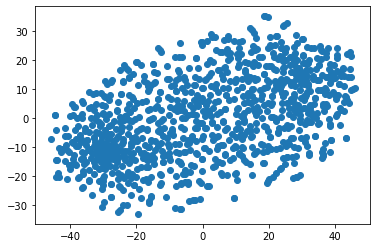

In [42]:
plt.scatter(tsne[:,0],tsne[:,1])

### Get Recommendation

In [284]:
def get_recommendation(name,k_indecies,k_distances,features_df,df):
    index = np.where(features_df.index == name)
    neighbours =  k_indecies[index].tolist()[0][1:21]
    distance = k_distances[index][0].tolist()
    for i,neighbour in enumerate(neighbours):
            print(df['name'].loc[neighbour],':',distance[i+1])

In [285]:
get_recommendation('WH Hotel',indecies,distances,features_df,hotels)

Hampton Inn Suites Bolingbrook : 0.00031999665782755926
Warwick Stone 55 Hotel : 0.00039106418995071834
Riccarton mall motel : 0.0004011795523822803
Freehand New York : 0.00041712764852142037
Twinkle Valley : 0.0004232996844039105
Comfort Suites Eugene : 0.0004318326493316649
Hotel Lauri : 0.0004333007811495593
Red Roof PLUS+ Boston - Mansfield/ Foxboro : 0.00043917676886340296
Saifi Suites : 0.0004399030046252639
Victor Harbor Holiday and Cabin Park : 0.0004503574135878985
Bavaria Boutique Hotel : 0.00045650471686076166
B&B Piazza Vittorio : 0.0004608943249682085
Hotel Niko : 0.0004726254644003003
Best Western Plus Franklin Square Inn Troy/Albany : 0.00047305280511955594
The Settlement Hotel : 0.00048173210007818046
Quality Inn & Suites Plano East - Richardson : 0.0004847836041942388
Econo Lodge : 0.0004847836041942388
Haymarket Hub Hotel : 0.0004858240401901526
Best Western Plus University Inn : 0.000487748450533676


In [86]:
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm

In [289]:
def similarity(one,two,df):
    one = df.loc[one]
    two = df.loc[two]
    return np.dot(one,two)/ np.multiply(norm(one),norm(two))

In [290]:
similarity("Hampton Inn Suites Bolingbrook","Warwick Stone 55 Hotel",features_df)

0.9994265631819792

## Places Recommender

#### Reading Data

In [43]:
places = pd.read_csv('places_features_dataset.csv')

In [44]:
places.head()

,city,id,name,rate,kinds,distance,coordinates
0,Milan,W290222578,Monumento a Vittorio Emanuele II,3,"historic,monuments_and_memorials,urban_environ...",21.220297,"{9.189259, 45.464199}"
1,Milan,Q3691002,Coperto dei Figini,3,"palaces,architecture,historic_architecture,int...",32.663493,"{9.18977, 45.4645}"
2,Milan,W163757278,Galleria Vittorio Emanuele II,7,"historic_architecture,architecture,urban_envir...",67.114911,"{9.190026, 45.464752}"
3,Milan,Q32118427,portici settentrionali di piazza Duomo,6,"palaces,architecture,historic_architecture,int...",70.273000,"{9.19, 45.464802}"
4,Milan,Q31849058,Hotel Diurno Cobianchi,6,"historic_architecture,architecture,interesting...",78.373210,"{9.18892, 45.46484}"


In [45]:
places.describe()

,rate,distance
count,111527.000000,111527.000000
mean,1.696109,37731.233851
std,1.562369,91957.422363
min,1.000000,0.099657
25%,1.000000,1074.748024
50%,1.000000,3514.676988
75%,1.000000,21882.064359
max,7.000000,998325.729116


In [46]:
cities_set = set(places['city'])
cities_list = [c for c in cities_set]
places['city_id'] = places['city'].apply(lambda city: cities_list.index(city))
places['city_id']

0          64
1          64
2          64
3          64
4          64
         ... 
111522    105
111523    105
111524    105
111525    105
111526    105
Name: city_id, Length: 111527, dtype: int64

In [47]:
places_features_df = pd.DataFrame(places['city_id'])
places_features_df = places_features_df.rename(index = places['name'])
places_features_df.head()

,city_id
Monumento a Vittorio Emanuele II,64
Coperto dei Figini,64
Galleria Vittorio Emanuele II,64
portici settentrionali di piazza Duomo,64
Hotel Diurno Cobianchi,64


In [48]:
p_features = set()
places['kinds'].apply(lambda item: [p_features.add(x) for x in str(item).split(',')])
col_names = places_features_df.columns
places_features = extract_features(places['kinds'],p_features)

In [273]:
places_features_df = pd.DataFrame(places_features,columns=p_features)
# places_features_df.insert(loc=0,column='city_id',value=places['city_id'])
places_features_df = places_features_df.rename(index = places['name'])
places_features_df.head()

,banks,biographical_museums,hindu_temples,lighthouses,nature_reserves_others,archaeology,moveable_bridges,gardens_and_parks,industrial_facilities,cafes,...,interesting_places,menhirs,dams,motels,canyons,islands,other_museums,other_bridges,computer_museums,fashion_museums
Monumento a Vittorio Emanuele II,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Coperto dei Figini,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Galleria Vittorio Emanuele II,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
portici settentrionali di piazza Duomo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hotel Diurno Cobianchi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
p_knn = NearestNeighbors(n_neighbors=20,metric='cosine')
p_knn.fit(places_features_df)

NearestNeighbors(metric='cosine', n_neighbors=20)

In [51]:
p_distances,p_indecies = p_knn.kneighbors(places_features_df)

In [287]:
get_recommendation('Coperto dei Figini',p_indecies,p_distances,places_features_df,places)

Phra Ratcha Wang Bowon Sathan Phimuk : 0.0
Dar Al Makhzen : 0.0
Thewawes Post Office : 0.0
Palácio da Calçada de Santana : 0.0
Palácio Albergaria : 0.0
Palais Schwerin : 0.0
Bang Leng Palace : 0.0
วังจันทรเกษม : 0.0
palais des ducs de Savoie : 0.0
Palau Episcopal : 0.0
Palácio Caldas : 0.0
Palácio dos Condes dos Arcos : 0.0
Palacio Maldá : 0.0
วังสะพานขาว : 0.0
วังจักรพงษ์ : 0.0
Ateneu Comercial de Lisboa : 0.0
El Glaoui Palace, Fez : 0.0
Phra Racha Wang Derm : 0.0
Ladawan palace : 0.0


In [293]:
similarity('Palau Episcopal','Phra Racha Wang Derm',places_features_df) 


1.0

In [52]:
tsne_p = TSNE().fit_transform(p_indecies[:1000])

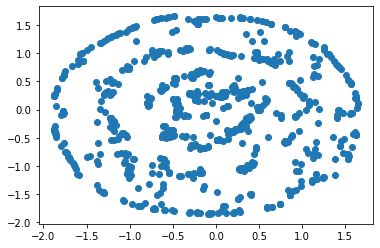

In [53]:
plt.scatter(tsne_p[:,0],tsne_p[:,1])